In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from time import process_time
import pickle

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, accuracy_score

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/Train set.csv')
test = pd.read_csv('data/Test set.csv')
y = pd.read_csv('data/Set labels.csv')

df = train.merge(y, on='id')
y_name = 'status_group'
print(df.shape)
df.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Exploratary data analysis

## Column types and meanings

looking at columns data types and unique values

In [3]:
df_data_types = df.dtypes
print(df_data_types.unique())
df_data_types

[dtype('int64') dtype('float64') dtype('O')]


id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [4]:
df.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [5]:
print(df['public_meeting'].unique(), df['permit'].unique())

[True nan False] [False True nan]


In [6]:
#public_meeting and permit are boolean features with NAs. We should convert them to float
df['public_meeting'] = df['public_meeting'].astype('float64')
df['permit'] = df['permit'].astype('float64')

#date should be stored as datetime
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

#recorded_by contains only one unique meaning. Should be dropped
df = df.drop(['recorded_by'], axis=1) 

#This columns are truly categorical
df['district_code'] = df['district_code'].astype('str')
df['region_code'] = df['region_code'].astype('str')
df_data_types = df.dtypes

Let's devide all features in 5 groups of data to manipulate them easily

In [7]:
columns = list(df.columns)
cat_columns = []
big_cat_columns = []
rank_columns = []
num_columns = []
bool_columns = []
dict_col_values = dict()
dict_col_types = dict()

for col in tqdm(columns):
    dict_col_values[col] = df[col].unique().tolist()
    col_type = str(df_data_types[col])
    n_values = df[col].nunique()
    values = df[col].copy()

    if col_type == 'object' and n_values <= 27:
        values = values.replace(np.nan, 'none')
        
        cat_columns.append(col)
        dict_col_types[col] = 'cat'
        
    elif col_type == 'object' and n_values > 27:
        big_cat_columns.append(col)
        dict_col_types[col] = 'big_cat'
        
    elif col_type in ['int64', 'float64'] and 2 < n_values < 21:
        rank_columns.append(col)
        dict_col_types[col] = 'rank'
        
    elif col_type in ['int64', 'float64'] and 2 >= n_values:
        bool_columns.append(col)
        dict_col_types[col] = 'bool'
    else:
        num_columns.append(col)
        dict_col_types[col] = 'num'


  0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
if 'id' in num_columns:
    num_columns.remove('id')
    
if 'date_recorded' in num_columns:
    num_columns.remove('date_recorded')
    
if y_name in cat_columns:
    cat_columns.remove(y_name)

## Working with missing values

In [9]:
df.isna().sum().sum()

46094

In [10]:
n_rows = df.shape[0]
number_na = n_rows - df.notna().sum()
df_columns = pd.DataFrame((number_na/n_rows)).reset_index()
df_columns.columns = ['col_name', 'NA_rate']
df_columns['col_type'] = df_columns.col_name.apply(lambda x: dict_col_types[x])
X_columns = num_columns+rank_columns+big_cat_columns+cat_columns
df_columns = df_columns.query('col_name in @X_columns')
df_columns_with_NA = df_columns.sort_values(by='NA_rate', ascending=False)[df_columns.NA_rate>0]
df_columns_with_NA

,col_name,NA_rate,col_type
20,scheme_name,0.474175,big_cat
19,scheme_management,0.065269,cat
5,installer,0.061532,big_cat
3,funder,0.061195,big_cat
11,subvillage,0.006246,big_cat


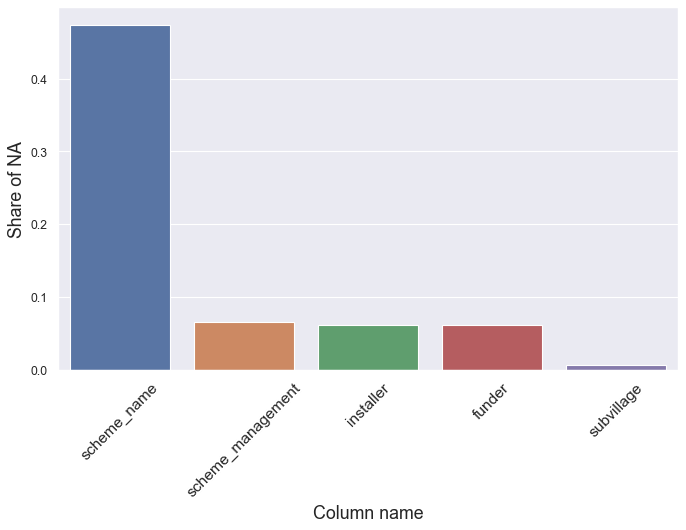

In [11]:
plt.figure(figsize= (10, 6), dpi=80)
sns.barplot(data=df_columns_with_NA, x='col_name', y='NA_rate')
plt.xticks(rotation=45)
plt.xticks(fontsize=14)
plt.xlabel('Column name', fontsize=16)
plt.ylabel('Share of NA', fontsize=16)
plt.show()

In [12]:
# dropping scheme_name because it contains too much NA's, almost a half
df1 = df.drop(['scheme_name'], axis=1).dropna()

if 'scheme_name' in big_cat_columns:
    big_cat_columns.remove('scheme_name')

In [13]:
df1.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional


# Trivial model

## Preprocessing

In [14]:
#use only numerical data to build trivial model
df1 = df1.drop(big_cat_columns+cat_columns+['date_recorded'], axis=1)
df1 = df1.drop(['id'], axis=1) 
df1.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,public_meeting,permit,construction_year,status_group
0,6000.0,1390,34.938093,-9.856322,0,109,1.0,0.0,1999,functional
2,25.0,686,37.460664,-3.821329,0,250,1.0,1.0,2009,functional
3,0.0,263,38.486161,-11.155298,0,58,1.0,1.0,1986,non functional
5,20.0,0,39.172796,-4.765587,0,1,1.0,1.0,2009,functional
6,0.0,0,33.362410,-3.766365,0,0,1.0,1.0,0,non functional


In [15]:
# we need to scale data because our trivial model is linear regression
df1[rank_columns+num_columns] = StandardScaler().fit_transform(df1[rank_columns+num_columns])

In [16]:
# split data for train and test

X = df1.drop(y_name, axis=1)
y = df1[y_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, shuffle=True, stratify=y)

<AxesSubplot:>

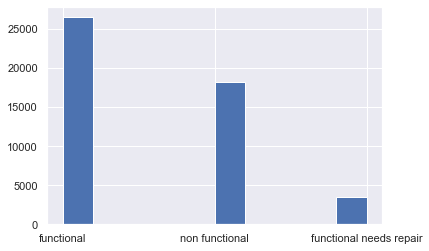

In [17]:
df1[y_name].hist()

### Models

In [18]:
def results(y_test, y_pred, time = 0):
    
    """Print metrics of classification of models"""
    
    print(f'\nAccuracy of model {round(accuracy_score(y_test, y_pred), 4)}\n')
    print(f'F0.5-macro of model {round(metrics.fbeta_score(y_test, y_pred, beta=0.5,average="macro"), 4)}')
    print(f'F0.5-weighted of model {round(metrics.fbeta_score(y_test, y_pred, beta=0.5,average="weighted"), 4)}\n')
    
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    
    if time != 0:
        print('\nCode running time - ' + str(round(time, 4)) + ' sec')
        

In [19]:
def check_all_models(models, model_names, X_train, X_test, y_train, y_test):
    """Returns fitted models. Prints results of model prediction on test set"""
    
    fitted_models = []
    for i in range(len(models)):
        print(f'************************** {model_names[i]} ****************************')
        start_time = process_time()

        model = models[i]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        finish_time = process_time()
        sec = finish_time - start_time
        
        results(y_test, y_pred, sec)
        
        fitted_models.append(model)
        
        print('\n\n----------------------------------------------------------------------\n')
        
    return fitted_models

In [20]:
models = [LogisticRegression(max_iter=2000, random_state=42)]
model_names = ['Log Reg']
fitted_models = check_all_models(models, model_names, X_train, X_test, y_train, y_test)

************************** Log Reg ****************************

Accuracy of model 0.5618

F0.5-macro of model 0.3359
F0.5-weighted of model 0.4861

                         precision    recall  f1-score   support

             functional       0.57      0.88      0.69      7955
functional needs repair       0.00      0.00      0.00      1050
         non functional       0.52      0.20      0.29      5482

               accuracy                           0.56     14487
              macro avg       0.36      0.36      0.33     14487
           weighted avg       0.51      0.56      0.49     14487


Code running time - 1.2188 sec


----------------------------------------------------------------------



# More details to data

We need to explore data more precisely to find some patterns that we can use

## Numerical columns research

In [21]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,public_meeting,permit,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,56066.000000,56344.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,179.909983,0.909838,0.689550,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,471.482176,0.286416,0.462682,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,25.000000,1.000000,1.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,215.000000,1.000000,1.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,30500.000000,1.000000,1.000000,2013.000000


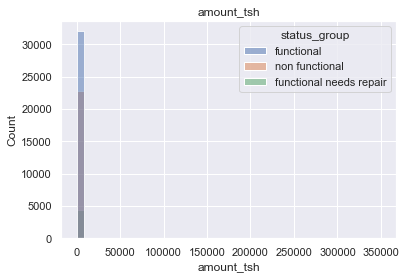

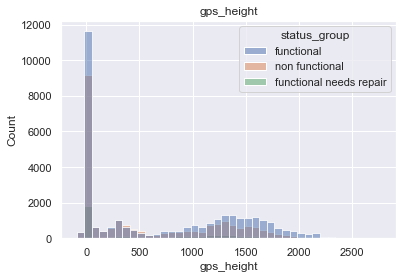

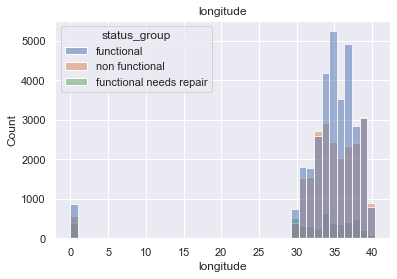

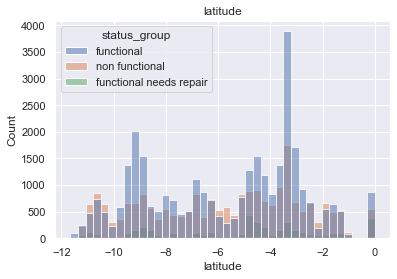

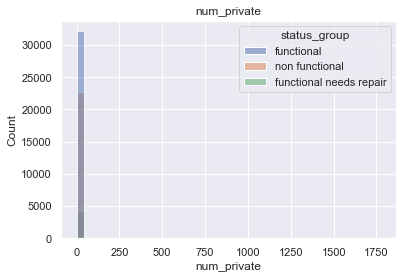

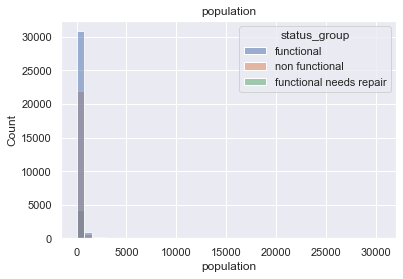

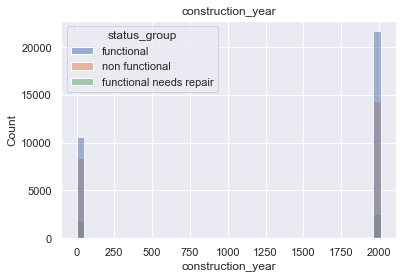

In [22]:
# let's plot histograms for every numerical column
for col in (num_columns+rank_columns):
    sns.histplot(data=df, x=col, hue=y_name,bins=40)
    plt.title(col)
    plt.show()

Looks like that data provider tried to fill missing values with 0

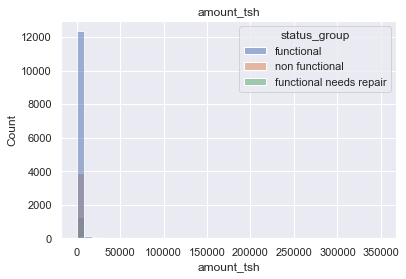

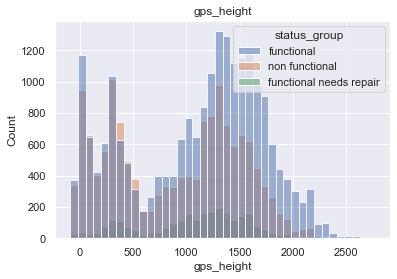

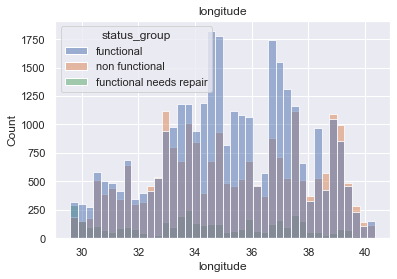

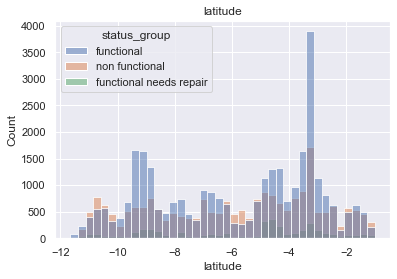

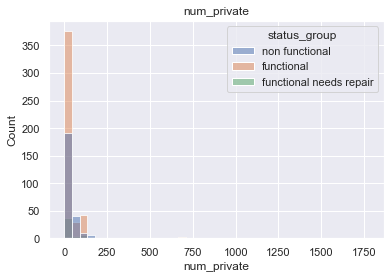

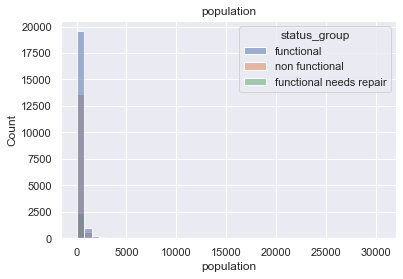

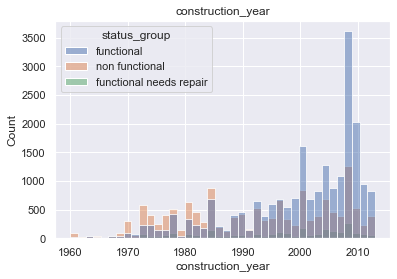

In [23]:
# show data without zeros and means near too zeros
for col in (num_columns):
    df_loc = df[[col, y_name]]
    df_loc = df_loc[abs(df_loc[col]) > 0.01]
    sns.histplot(data=df_loc, x=col, hue=y_name,bins=40)
    plt.title(col)
    plt.show()

amount_tsh, num_private, population have some outliers

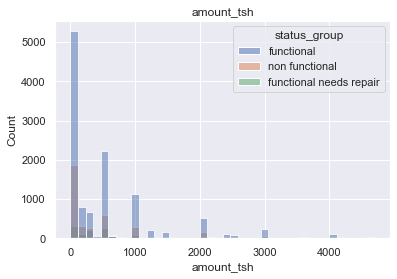

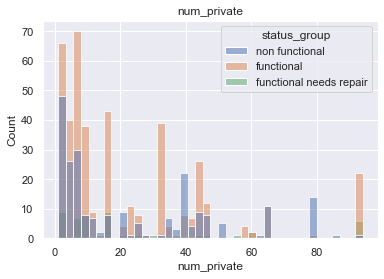

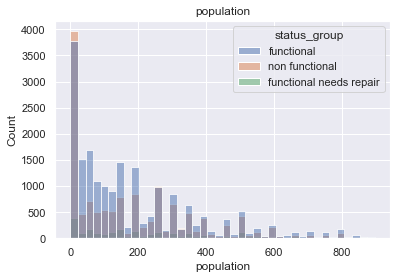

In [24]:
num_outliers = ['amount_tsh', 'num_private', 'population']

for col in num_outliers:
    df_loc = df[[col, y_name]]
    df_loc = df_loc[abs(df_loc[col]) != 0]
    df_loc = df_loc[df_loc[col]<df_loc[col].quantile(q=0.95)]
    sns.histplot(data=df_loc, x=col, hue=y_name,bins=40)
    plt.title(col)
    plt.show()

<AxesSubplot:>

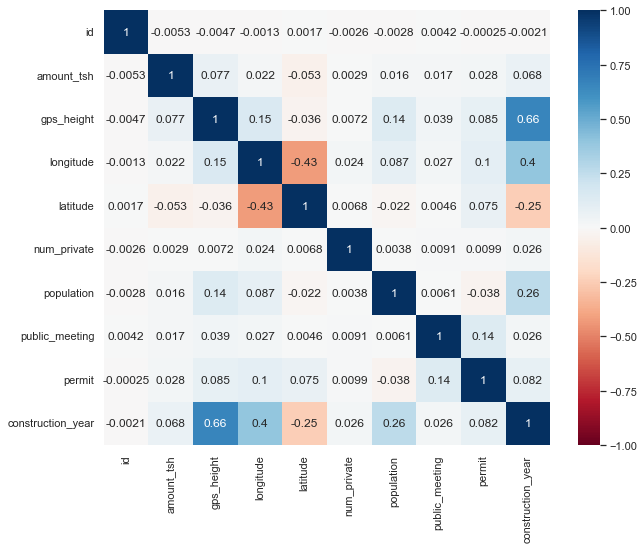

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap="RdBu")

There is no strong correlation between numerical factors

## Hidden NAs

In [26]:
# let's find hidden missing values in our dataframe
hidden_na_rate = []

for col in df_columns['col_name']:
    df_loc = df[col]
    if col in num_columns + rank_columns:

        df_loc = df_loc[abs(df_loc) < 0.01]
        rate = len(df_loc)/len(df)
    else:
        df_loc = df_loc[(df_loc=='None')|(df_loc=='none')|(df_loc=='NONE')]
        rate = len(df_loc)/len(df)
    
    hidden_na_rate.append(rate)

In [27]:
df_columns['hidden_na_rate'] = hidden_na_rate
df_columns['entire_na_rate'] = df_columns['hidden_na_rate'] + df_columns['NA_rate']
df_columns_NA2 = df_columns[df_columns['entire_na_rate']>0].sort_values(by='entire_na_rate', ascending=False)
df_columns_NA2

,col_name,NA_rate,col_type,hidden_na_rate,entire_na_rate
9,num_private,0.000000,num,0.987256,0.987256
1,amount_tsh,0.000000,num,0.700993,0.700993
20,scheme_name,0.474175,big_cat,0.011263,0.485438
17,population,0.000000,num,0.359949,0.359949
22,construction_year,0.000000,num,0.348636,0.348636
4,gps_height,0.000000,num,0.344074,0.344074
19,scheme_management,0.065269,cat,0.000017,0.065286
5,installer,0.061532,big_cat,0.000000,0.061532
3,funder,0.061195,big_cat,0.000034,0.061229
8,wpt_name,0.000000,big_cat,0.060017,0.060017


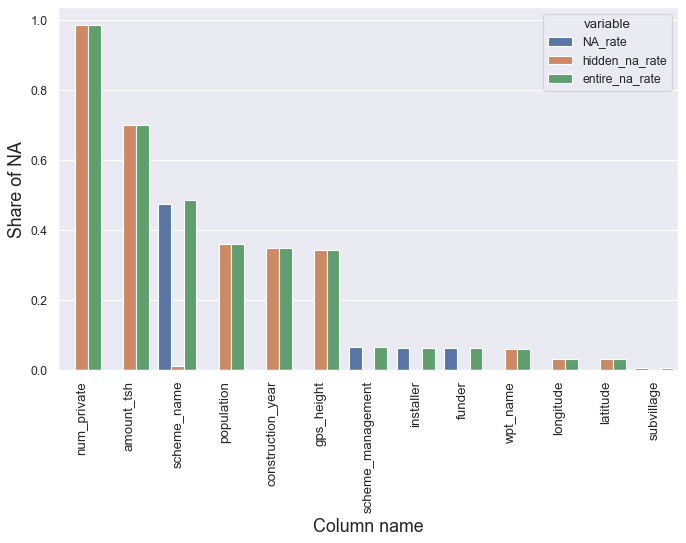

In [28]:
df_melt = pd.melt(df_columns_NA2, id_vars=['col_name'], value_vars=['NA_rate', 'hidden_na_rate', 'entire_na_rate'])

plt.figure(figsize= (10, 6), dpi=80)
sns.barplot(data=df_melt, x='col_name', y='value', hue='variable')
plt.xticks(rotation=90)
plt.xticks(fontsize=12)
plt.xlabel('Column name', fontsize=16)
plt.ylabel('Share of NA', fontsize=16)
plt.show()

# Categorical

In [29]:
df[cat_columns].head()

,basin,region,region_code,district_code,scheme_management,extraction_type,extraction_type_group,extraction_type_class,management,management_group,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,Lake Nyasa,Iringa,11,5,VWC,gravity,gravity,gravity,vwc,user-group,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,Lake Victoria,Mara,20,2,Other,gravity,gravity,gravity,wug,user-group,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,Pangani,Manyara,21,4,VWC,gravity,gravity,gravity,vwc,user-group,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,Ruvuma / Southern Coast,Mtwara,90,63,VWC,submersible,submersible,submersible,vwc,user-group,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,Lake Victoria,Kagera,18,1,NaN,gravity,gravity,gravity,other,other,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


basin


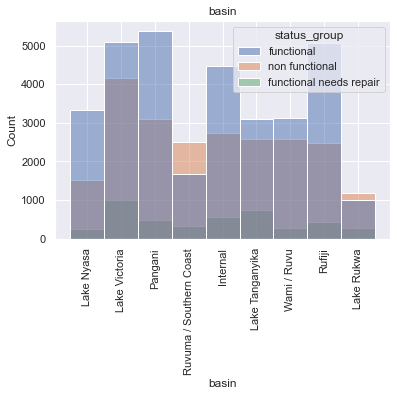

region


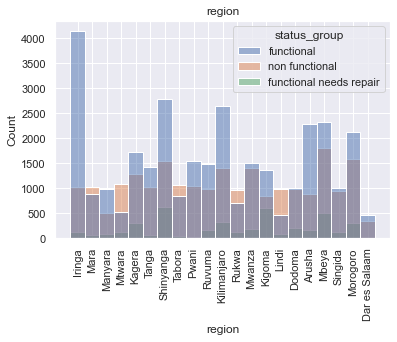

region_code


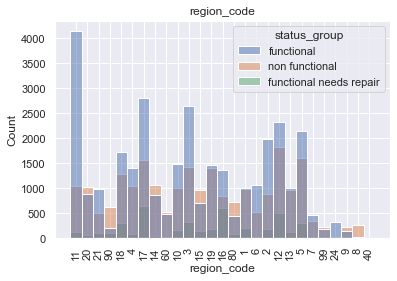

district_code


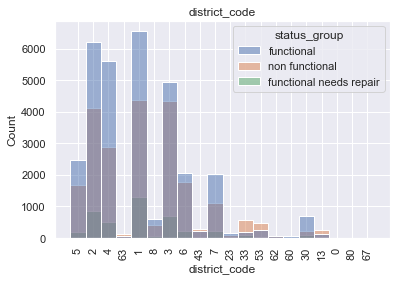

scheme_management


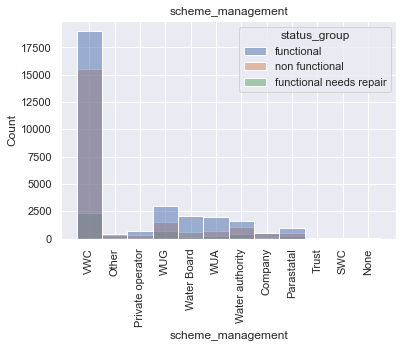

extraction_type


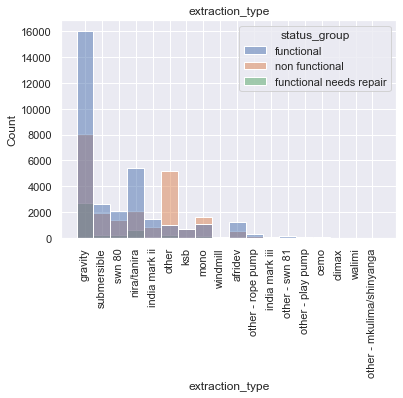

extraction_type_group


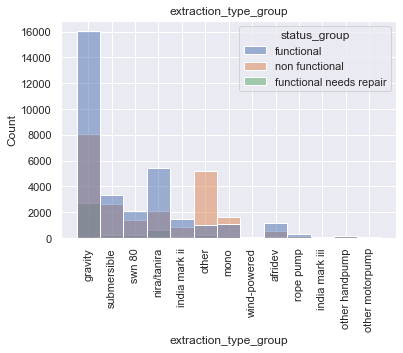

extraction_type_class


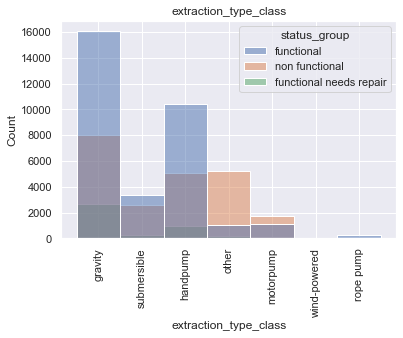

management


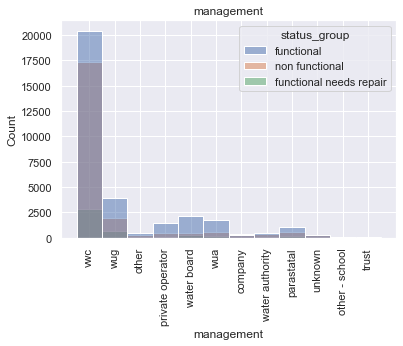

management_group


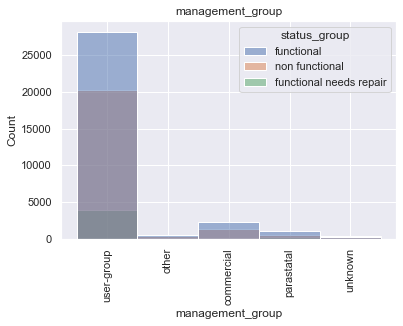

payment


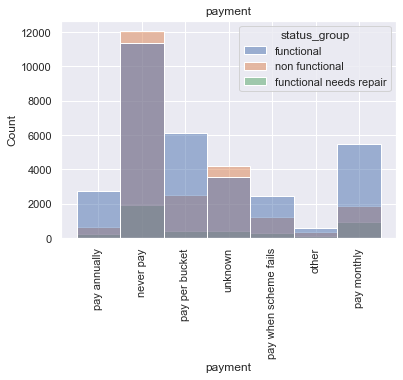

payment_type


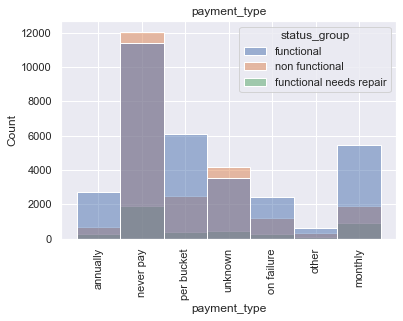

water_quality


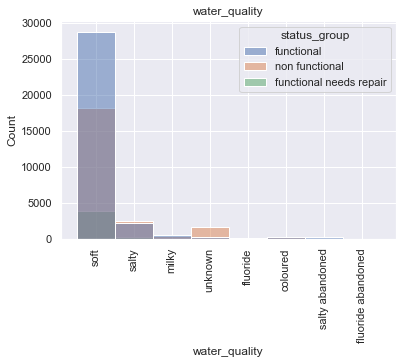

quality_group


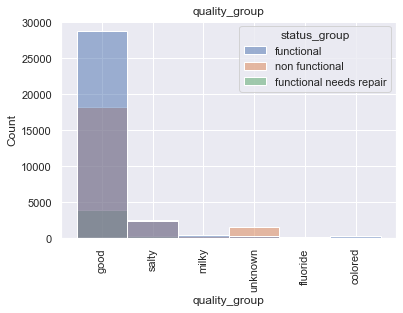

quantity


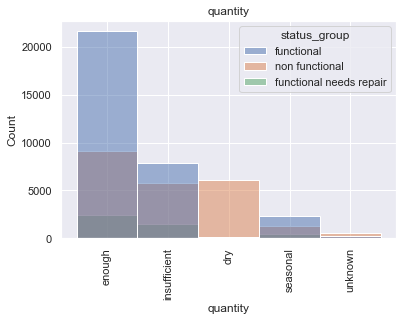

quantity_group


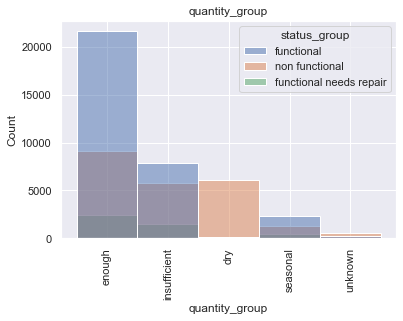

source


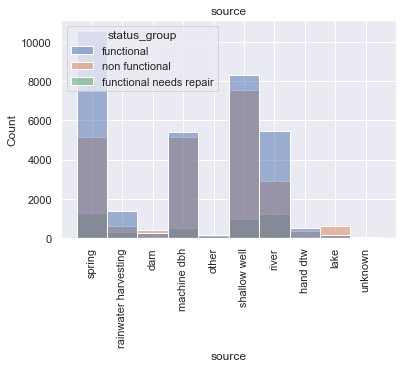

source_type


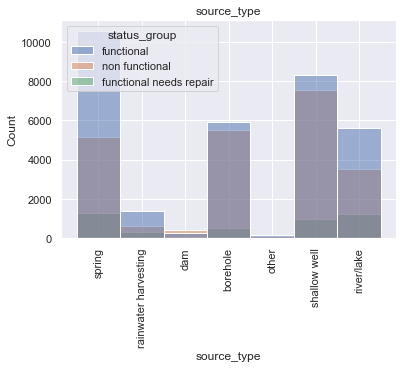

source_class


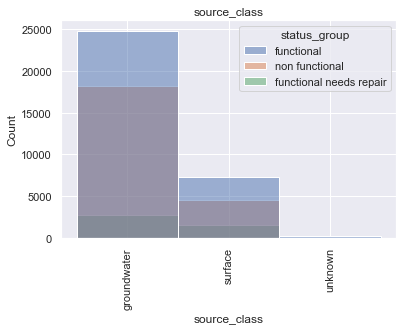

waterpoint_type


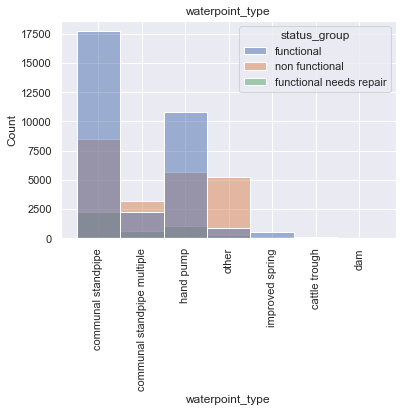

waterpoint_type_group


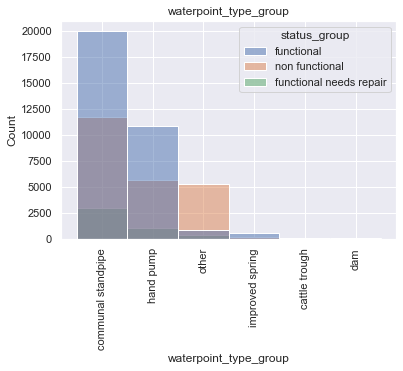

In [30]:
# show histograms for all cat columns
for col in (cat_columns):
    print(col)
    df_loc = df[[col, y_name]].dropna()
    sns.histplot(data=df_loc, x=col, hue=y_name,bins=df_loc[col].nunique())
    plt.title(col)
    plt.xticks(rotation=90)

    plt.show()

1. Extraction type, extraction type group and extraction type class looks like parts of the same. Two of them can be dropped (extraction type class and group)
2. Same with management and management group. Drop management group
3. Payment and payment type look absolutely the same. Need more detailed exploration
4. Water group and quality group describe the same. Drop quality group
5. Quantity and quantity group are absolutely the same. Need more detailed exploration
6. Source, source type and source class describe the same. Drop source type and source class
7. Waterpoint type and waterpoint type group describe the same. Drop waterpoint type group

<AxesSubplot:xlabel='payment', ylabel='payment_type'>

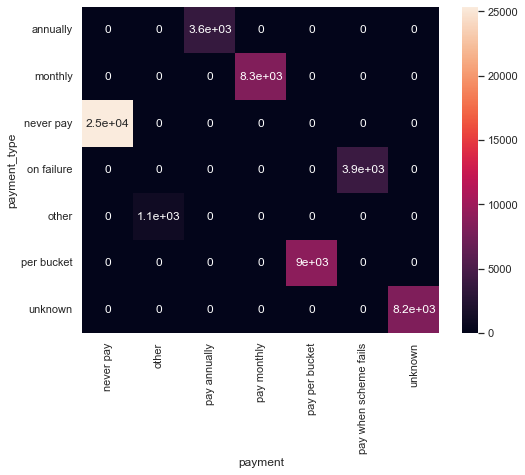

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.crosstab(df['payment_type'], df['payment']), annot=True)

<AxesSubplot:xlabel='quantity_group', ylabel='quantity'>

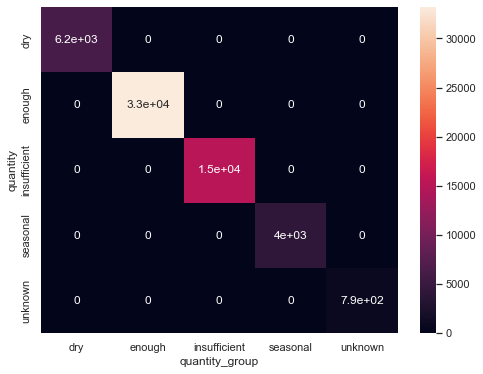

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.crosstab(df['quantity'], df['quantity_group']), annot=True)

We can drop payment_type and quantity_group because they have duplicates

In [33]:
cat_to_drop = ['extraction_type_class', 'extraction_type_group', 'management_group', 'payment_type', 'quality_group', 
               'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

cat_columns_v2 = list(set(cat_columns) - set(cat_to_drop))
cat_columns_v2

['payment',
 'water_quality',
 'scheme_management',
 'region',
 'extraction_type',
 'waterpoint_type',
 'district_code',
 'region_code',
 'basin',
 'management',
 'source',
 'quantity']

## big_cat columns

In [34]:
df[big_cat_columns]

,funder,installer,wpt_name,subvillage,lga,ward
0,Roman,Roman,none,Mnyusi B,Ludewa,Mundindi
1,Grumeti,GRUMETI,Zahanati,Nyamara,Serengeti,Natta
2,Lottery Club,World vision,Kwa Mahundi,Majengo,Simanjiro,Ngorika
3,Unicef,UNICEF,Zahanati Ya Nanyumbu,Mahakamani,Nanyumbu,Nanyumbu
4,Action In A,Artisan,Shuleni,Kyanyamisa,Karagwe,Nyakasimbi
...,...,...,...,...,...,...
59395,Germany Republi,CES,Area Three Namba 27,Kiduruni,Hai,Masama Magharibi
59396,Cefa-njombe,Cefa,Kwa Yahona Kuvala,Igumbilo,Njombe,Ikondo
59397,NaN,NaN,Mashine,Madungulu,Mbarali,Chimala
59398,Malec,Musa,Mshoro,Mwinyi,Chamwino,Mvumi Makulu


funder 1897
installer 2145
wpt_name 37400
subvillage 19287
lga 125
ward 2092


<AxesSubplot:>

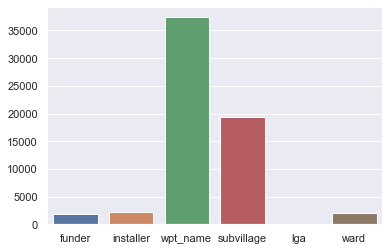

In [35]:
x = []
y = []
for col in (big_cat_columns):
    print(col, df[col].nunique())
    x.append(col)
    y.append(df[col].nunique())
    
sns.barplot(x=x, y=y)

big_cat columns contain too muсh categorical values to use one-hot encoding. We don't need to continue work with them

# Preprocessing

In [36]:
X_columns = num_columns+bool_columns+rank_columns+cat_columns_v2 + ['date_recorded']
X = df[X_columns]
num_cols_to_log = ['amount_tsh', 'num_private', 'population']
    
df2 = X
df2[y_name] = df[y_name]

print(df2.shape)
df2.head()

(59400, 23)


,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,public_meeting,permit,payment,...,extraction_type,waterpoint_type,district_code,region_code,basin,management,source,quantity,date_recorded,status_group
0,6000.0,1390,34.938093,-9.856322,0,109,1999,1.0,0.0,pay annually,...,gravity,communal standpipe,5,11,Lake Nyasa,vwc,spring,enough,2011-03-14,functional
1,0.0,1399,34.698766,-2.147466,0,280,2010,NaN,1.0,never pay,...,gravity,communal standpipe,2,20,Lake Victoria,wug,rainwater harvesting,insufficient,2013-03-06,functional
2,25.0,686,37.460664,-3.821329,0,250,2009,1.0,1.0,pay per bucket,...,gravity,communal standpipe multiple,4,21,Pangani,vwc,dam,enough,2013-02-25,functional
3,0.0,263,38.486161,-11.155298,0,58,1986,1.0,1.0,never pay,...,submersible,communal standpipe multiple,63,90,Ruvuma / Southern Coast,vwc,machine dbh,dry,2013-01-28,non functional
4,0.0,0,31.130847,-1.825359,0,0,0,1.0,1.0,never pay,...,gravity,communal standpipe,1,18,Lake Victoria,other,rainwater harvesting,seasonal,2011-07-13,functional


In [37]:
#feature engeniring

#filling missing values with medians
const_year_med_no_0 = df2[df2['construction_year'] != 0]['construction_year'].median()
lat_med_no_0 = df2[df2['latitude'] != 0]['latitude'].median()
long_med_no_0 = df2[df2['longitude'] != 0]['longitude'].median()

df2['construction_year'] = df2['construction_year'].replace(0, const_year_med_no_0)
df2['latitude'] = df2['latitude'].replace(0, lat_med_no_0)
df2['longitude'] = df2['longitude'].replace(0, long_med_no_0)

# calculating new features with distance
Dodoma_coordinates = [-6.17221, 35.7395]
Dar_es_salama_coordinates = [-6.82349, 39.2695]

df2['dist_to_Dodoma'] = np.sqrt((df2['latitude'] - Dodoma_coordinates[0])**2 + (df2['longitude'] - Dodoma_coordinates[1])**2)
df2['dist_to_Dar_es_salama'] = np.sqrt((df2['latitude'] - Dar_es_salama_coordinates[0])**2 + (df2['longitude'] - Dar_es_salama_coordinates[1])**2)

# calculating new features from date columns
df2['year'] = df2['date_recorded'].dt.year
df2['month'] = df2['date_recorded'].dt.month_name()
df2['age'] = df2['year'] - df2['construction_year']

df2 = df2.drop(['date_recorded'], axis=1)

#marking hidden NAs
for col in num_columns:
    df2[col+'_na'] = df2[col].apply(lambda x: 1 if x < 0.01 else 0)  
    
for col in num_outliers:
    outliers_threshold = df[col].quantile(q=0.95)
    df2[col+'_outliers'] = df2[col].apply(lambda x: 1 if x > outliers_threshold else 0)  

df2 = df2.drop(num_cols_to_log,axis=1)

df2.head()

,gps_height,longitude,latitude,construction_year,public_meeting,permit,payment,water_quality,scheme_management,region,...,amount_tsh_na,gps_height_na,longitude_na,latitude_na,num_private_na,population_na,construction_year_na,amount_tsh_outliers,num_private_outliers,population_outliers
0,1390,34.938093,-9.856322,1999,1.0,0.0,pay annually,soft,VWC,Iringa,...,0,0,0,1,1,0,0,1,0,0
1,1399,34.698766,-2.147466,2010,NaN,1.0,never pay,soft,Other,Mara,...,1,0,0,1,1,0,0,0,0,0
2,686,37.460664,-3.821329,2009,1.0,1.0,pay per bucket,soft,VWC,Manyara,...,0,0,0,1,1,0,0,0,0,0
3,263,38.486161,-11.155298,1986,1.0,1.0,never pay,soft,VWC,Mtwara,...,1,0,0,1,1,0,0,0,0,0
4,0,31.130847,-1.825359,2000,1.0,1.0,never pay,soft,NaN,Kagera,...,1,1,0,1,1,1,0,0,0,0


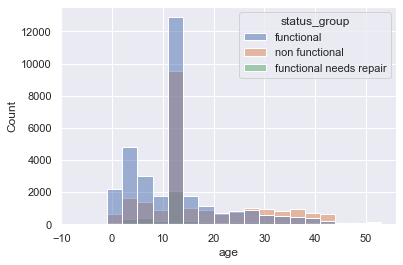

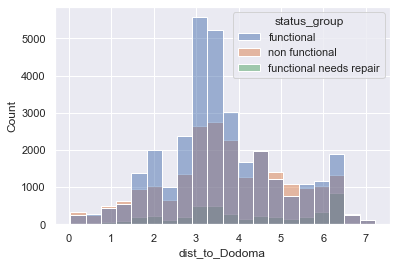

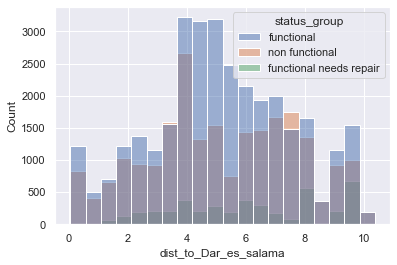

In [38]:
sns.histplot(data=df2,x='age',hue=y_name,bins=20)
plt.show()

sns.histplot(data=df2,x='dist_to_Dodoma',hue=y_name,bins=20)
plt.show()

sns.histplot(data=df2,x='dist_to_Dar_es_salama',hue=y_name,bins=20)
plt.show()

In [39]:
df2 = X.dropna()
print(df2.shape)

(49841, 28)


In [40]:
#redefining column types

df_data_types = df2.dtypes

columns = list(df2.columns)
cat_columns = []
big_cat_columns = []
rank_columns = []
num_columns = []
dict_col_values = dict()
dict_col_types = dict()

for col in tqdm(columns):

    dict_col_values[col] = df2[col].unique().tolist()
    col_type = str(df_data_types[col])
    n_values = df2[col].nunique()
    values = df2[col].copy()

    if col_type == 'object' and n_values <= 21:
        values = values.replace(np.nan, 'none')
        
        cat_columns.append(col)
        dict_col_types[col] = 'cat'
        
    elif col_type == 'object' and n_values > 21:
        big_cat_columns.append(col)
        dict_col_types[col] = 'big_cat'
        
    elif col_type in ['int64', 'float64'] and n_values < 21:
        rank_columns.append(col)
        dict_col_types[col] = 'rank'
    else:
        num_columns.append(col)
        dict_col_types[col] = 'num'

  0%|          | 0/28 [00:00<?, ?it/s]

In [41]:
if 'id' in num_columns:
    num_columns.remove('id')
    
if 'date_recorded' in num_columns:
    num_columns.remove('date_recorded')
    
if y_name in cat_columns:
    cat_columns.remove(y_name)

In [42]:
# we get some features with date_recorded and can drop it 
df2 = df2.drop(['date_recorded'], axis=1)

In [43]:
# use one-hot encoding with get_dummies() to transform categorical features
df2 = pd.get_dummies(df2, columns=cat_columns, drop_first=True)
print(df2.shape)
df2.head()

(49841, 144)


,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,public_meeting,permit,region_code,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,6000.0,1390,34.938093,-9.856322,0,109,1999,1.0,0.0,11,...,0,0,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,0,250,2009,1.0,1.0,21,...,0,1,0,0,0,0,0,0,0,0
3,0.0,263,38.486161,-11.155298,0,58,1986,1.0,1.0,90,...,0,0,1,0,0,0,0,0,0,0
5,20.0,0,39.172796,-4.765587,0,1,2009,1.0,1.0,4,...,0,0,0,0,0,1,0,0,0,0
6,0.0,0,33.362410,-3.766365,0,0,2000,1.0,1.0,17,...,0,0,0,0,0,0,0,0,1,0


In [44]:
# Use standard scaler to scale features for Logistic regression and KNN
df2[num_columns] = StandardScaler().fit_transform(df2[num_columns])

In [45]:
X = df2.drop(y_name, axis=1)
y = df2[y_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, shuffle=True, stratify=y)

# Training models

In [47]:
models = [LogisticRegression(max_iter=2000, random_state=42),
          RandomForestClassifier(random_state=42),
          GradientBoostingClassifier(random_state=42),
          KNeighborsClassifier()]

model_names = ['Log Reg',
               'Random forest',
               'GBOOST',
               'KNN']

fitted_models = check_all_models(models, model_names, X_train, X_test, y_train, y_test)

************************** Log Reg ****************************

Accuracy of model 0.7423

F0.5-macro of model 0.6072
F0.5-weighted of model 0.723

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8215
functional needs repair       0.47      0.13      0.21      1101
         non functional       0.78      0.64      0.71      5637

               accuracy                           0.74     14953
              macro avg       0.66      0.56      0.57     14953
           weighted avg       0.73      0.74      0.72     14953


Code running time - 942.7812 sec


----------------------------------------------------------------------

************************** Random forest ****************************

Accuracy of model 0.7974

F0.5-macro of model 0.6993
F0.5-weighted of model 0.7913

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      8215


In [48]:
preds = []

for model in fitted_models:
    preds.append(model.predict(X_test))
preds_df = pd.DataFrame(preds, index=model_names)
mode_preds = preds_df.mode().T
stacking_pred = mode_preds[0]

results(y_test, stacking_pred)


Accuracy of model 0.7992

F0.5-macro of model 0.707
F0.5-weighted of model 0.79

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.84      8215
functional needs repair       0.60      0.28      0.38      1101
         non functional       0.85      0.74      0.79      5637

               accuracy                           0.80     14953
              macro avg       0.74      0.64      0.67     14953
           weighted avg       0.79      0.80      0.79     14953



# Grid search

using grid search to get optimal parameters for ML algorythms 

In [49]:
def grid_search(models, model_names, params, scorer, X_train, X_test, y_train, y_test):
    
    fitted_models = []
    
    for i in tqdm(range(len(models))):
        
        print(f'************************** {model_names[i]} ****************************')
        
        start_time = process_time()
        
        model = models[i]

        cv = KFold(n_splits=5, shuffle=True, random_state=5)

        gs_model = GridSearchCV(model, param_grid=params[i], cv=cv, n_jobs=-1, verbose=5, scoring=scorer)
        gs_model.fit(X_train, y_train)
        print(gs_model.best_params_)
        print('Best score: ', gs_model.best_score_)
        fitted_models.append(gs_model)

        y_pred = gs_model.predict(X_test)
        finish_time = process_time()
        sec = finish_time - start_time
        results(y_test, y_pred, sec)
        
        print('\n\n----------------------------------------------------------------------\n')
        
    return fitted_models

In [ ]:
models = [LogisticRegression(max_iter=2000),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          KNeighborsClassifier()]

model_names = ['Log Reg', 
               'Random forest',
               'XGBOOST',
               'KNN']

f1 = make_scorer(metrics.fbeta_score, average='weighted', beta=0.5)

params_grid = [
    { 
        'penalty': ['l1','l2'], 
        'C': np.logspace(-3, 3, num=7)
    }, 
    { 
        'n_estimators': [100, 200, 300, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [6, 8, 10, None],
        'criterion' :['gini', 'entropy']
    }, 
#     { 
#         'n_estimators' : [100,150,200,250],
#         'max_depth'    : [3, 6, 8, None],
#         'learning_rate' : np.logspace(-3,1,num=4)
#     }, 
    { 
        'n_neighbors':range(3,22,2),
        'weights': ["uniform", "distance"],
        'p': [3,1,2]
    }]

fitted_models = grid_search(models, model_names, params_grid, f1, X_train, X_test, y_train, y_test)

  0%|          | 0/3 [00:00<?, ?it/s]

************************** Log Reg ****************************
Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'C': 1.0, 'penalty': 'l2'}
Best score:  0.7165264812503847

Accuracy of model 0.7423

F0.5-macro of model 0.6072
F0.5-weighted of model 0.723

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8215
functional needs repair       0.47      0.13      0.21      1101
         non functional       0.78      0.64      0.71      5637

               accuracy                           0.74     14953
              macro avg       0.66      0.56      0.57     14953
           weighted avg       0.73      0.74      0.72     14953


Code running time - 717.375 sec


----------------------------------------------------------------------

************************** Random forest ****************************
Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'criterion': 'entropy', 'max_dept

In [ ]:
with open('fitted_models.pickle', 'wb') as f:
    pickle.dump(fitted_models, f)

In [ ]:
preds = []

for model in fitted_models:
    preds.append(model.predict(X_test))
preds_df = pd.DataFrame(preds, index=model_names)
mode_preds = preds_df.mode().T
stacking_pred = mode_preds[0]

results(y_test, stacking_pred)